# Microsoft Recommendations

In [1]:
# %run code/add_data.py
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,}'.format
from pandasql import sqldf
import json
import requests
import os
import seaborn as sns


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
#os.system("ls data/zippedData | grep sv > file_list.txt")




In [135]:
%run code/data_preparations.py
csv_dict.keys()


dict_keys(['bom.movie_gross', 'imdb.name.basics', 'imdb.title.akas', 'imdb.title.basics', 'imdb.title.crew', 'imdb.title.principals', 'imdb.title.ratings', 'rt.movie_info', 'rt.reviews', 'tmdb.movies', 'tmdb_genres', 'tmdb_imdb_gross', 'tmdb_imdb_gross_full', 'tmdb_movie_ids', 'tn.movie_budgets'])

<Figure size 432x288 with 0 Axes>

In [136]:
full_profit_df.head(2)
#csv_dict.get('tmdb_imdb_gross_full').info()

,id,tconst,title,release_date,revenue,budget,net_profit,year,vote_average,popularity,vote_count,runtime,genre_id
0,5,tt0113101,Four Rooms,1995-12-09,"4,257,354.0","4,000,000.0","257,354.0",1995,5,15,2123,98.0,"[80, 35]"
1,11,tt0076759,Star Wars,1977-05-25,"775,398,007.0","11,000,000.0","764,398,007.0",1977,8,90,16953,121.0,"[12, 28, 878]"


In [137]:
full_profit_by_genre.head(2)

,id,tconst,title,release_date,revenue,budget,net_profit,year,vote_average,popularity,vote_count,runtime,genre_id,genre
0,5,tt0113101,Four Rooms,1995-12-09,"4,257,354.0","4,000,000.0","257,354.0",1995,5,15,2123,98.0,80,Crime
1,93,tt0052561,Anatomy of a Murder,1959-07-01,"8,000,000.0","2,000,000.0","6,000,000.0",1959,7,16,693,161.0,80,Crime


In [218]:
full_profit_df=full_profit_df.query("year > 1990 and year < 2022 & runtime>60")
genre_summary_df=full_profit_by_genre.groupby(['genre'], as_index=False).mean().sort_values(by="revenue", ascending=False)[['genre','revenue']]

year_summary_df=full_profit_df.groupby(['year'], as_index=False).mean().sort_values(by="year")[['year','revenue']]
year_summary_df=year_summary_df[(year_summary_df["year"]>1995) & (year_summary_df["year"]<2022) ]
year_summary_df.head()

full_profit_df["year"]=full_profit_df["year"].astype(int)

#full_profit_year_df=full_profit_df.query("year > 1990 and year < 2022 & runtime>60")

In [215]:

full_profit_vote_df=full_profit_df.query("vote_count>200 & vote_count<20550").copy()
full_profit_vote_df.dropna(subset=["vote_count"], inplace=True)


full_profit_runtime_df=full_profit_df.query("runtime<200 & runtime>60 & revenue<1500000000").copy()
full_profit_runtime_df.dropna(subset=["runtime"], inplace=True)


full_profit_avgvote_df=full_profit_df.query("vote_average>0").copy()
full_profit_avgvote_df.dropna(subset=["vote_average"], inplace=True)


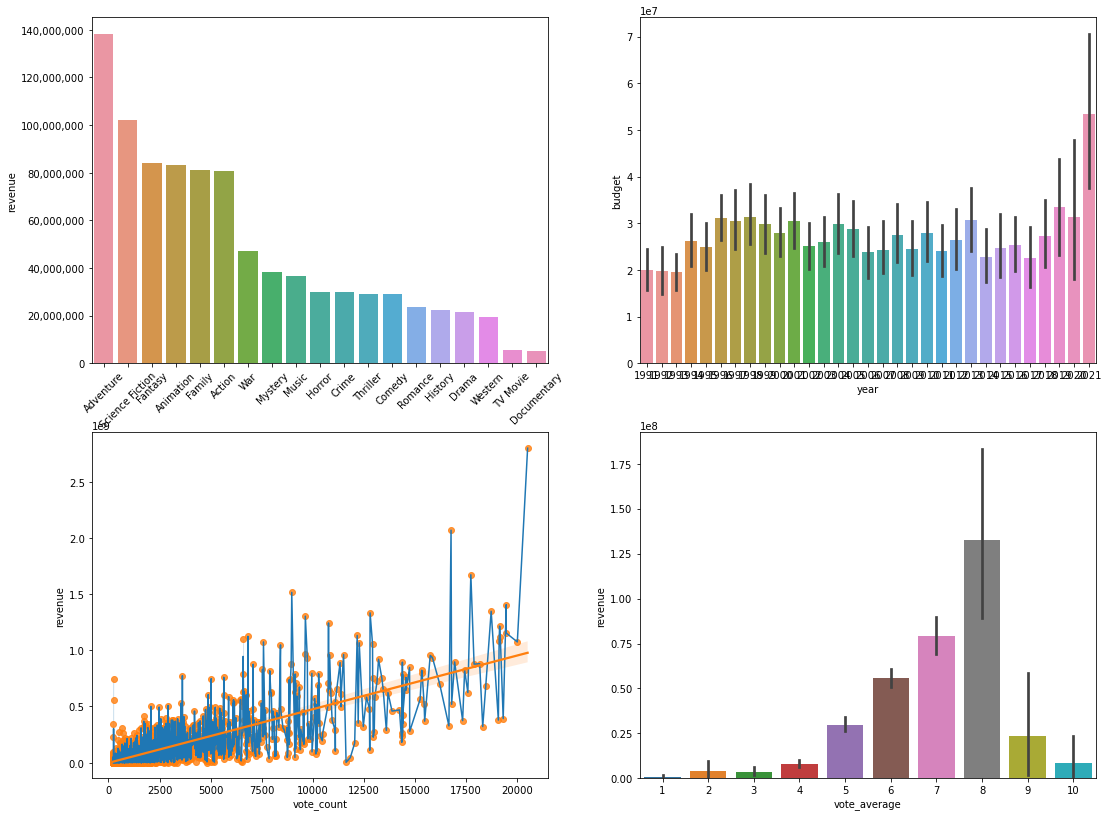

In [216]:

fig,ax=plt.subplots( nrows=2,ncols=2, figsize=(18,14))

pd.set_option('display.float_format', lambda x: '%.7f' % x)

num_of_ticks=list(range(len(genre_summary_df['genre'])))

sns.barplot(x='genre', y='revenue', data=genre_summary_df, ax=ax[0][0]);

ax[0][0].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[0][0].set_xticks(num_of_ticks);
ax[0][0].set_xticklabels(list(genre_summary_df['genre']),  rotation=45);

sns.barplot(x='year', y='budget', data=full_profit_year_df, ax=ax[0][1]);
sns.barplot(x='vote_average', y='revenue', data=full_profit_avgvote_df, ax=ax[1][1]);

sns.lineplot(x='vote_count', y='revenue', data=full_profit_vote_df, ax=ax[1][0]);
sns.regplot(x='vote_count', y='revenue', data=full_profit_vote_df, ax=ax[1][0]);






In [204]:
!ls images


profit_by_genre.png


In [200]:
None

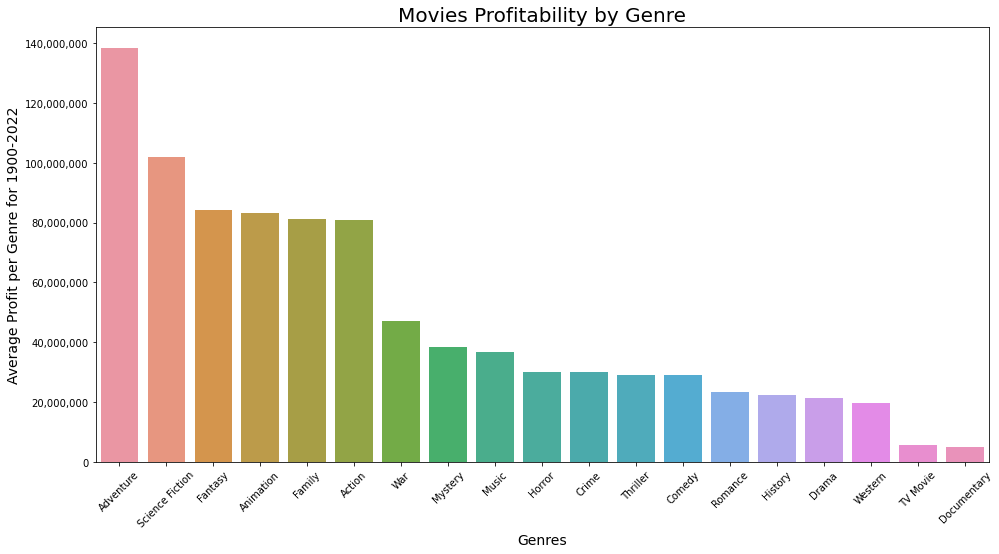

In [217]:
pd.set_option('display.float_format', lambda x: '%.7f' % x)

num_of_ticks=list(range(len(genre_summary_df['genre'])))

fig,ax=plt.subplots(  figsize=(16,8))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

sns.barplot(x='genre', y='revenue', data=genre_summary_df, ax=ax);
ax.set_xticks(num_of_ticks);
ax.set_xticklabels(list(genre_summary_df['genre']),  rotation=45);
ax.set_title("Movies Profitability by Genre", fontsize=20 )
ax.set_ylabel("Average Profit per Genre for 1900-2022", fontsize=14)
ax.set_xlabel("Genres", fontsize=14);

#fig.savefig('images/profit_by_genre.png')

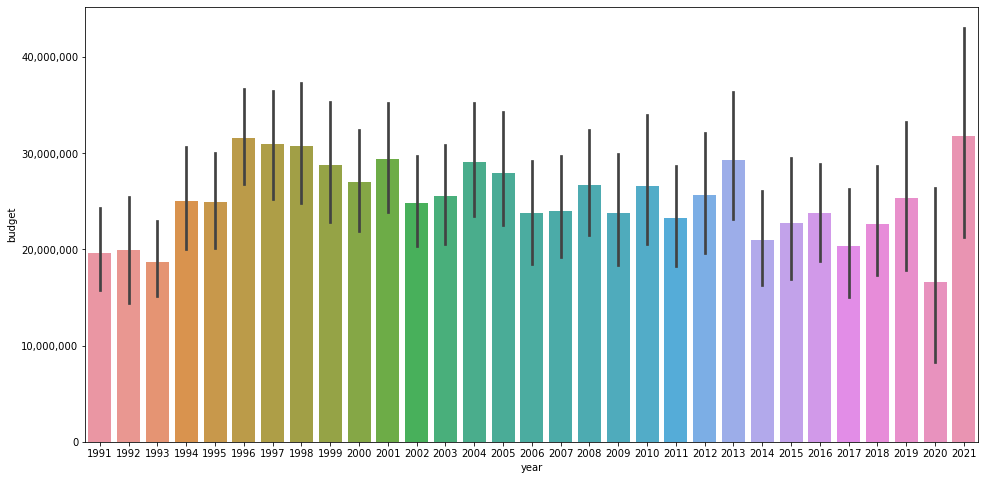

In [140]:
fig,ax=plt.subplots(  figsize=(16,8))

ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

#sns.barplot(x='year', y='revenue', data=year_summary_df, ax=ax);
sns.barplot(x='year', y='budget', data=full_profit_year_df, ax=ax);


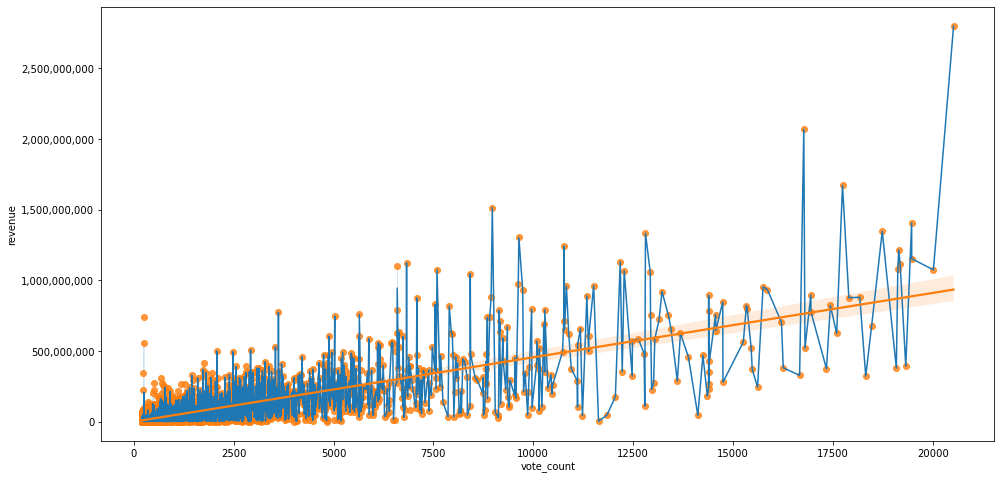

In [168]:
fig,ax=plt.subplots(  figsize=(16,8))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

#full_profit_pop_df=full_profit_df.query("popularity>20 and popularity<110")


#full_profit_pop_df=full_profit_df.query("popularity>20 and popularity<110")
#sns.lineplot(x='vote_count', y='revenue', data=full_profit_pop_df, ax=ax);


sns.lineplot(x='vote_count', y='revenue', data=full_profit_vote_df, ax=ax);

sns.regplot(x='vote_count', y='revenue', data=full_profit_vote_df, ax=ax);



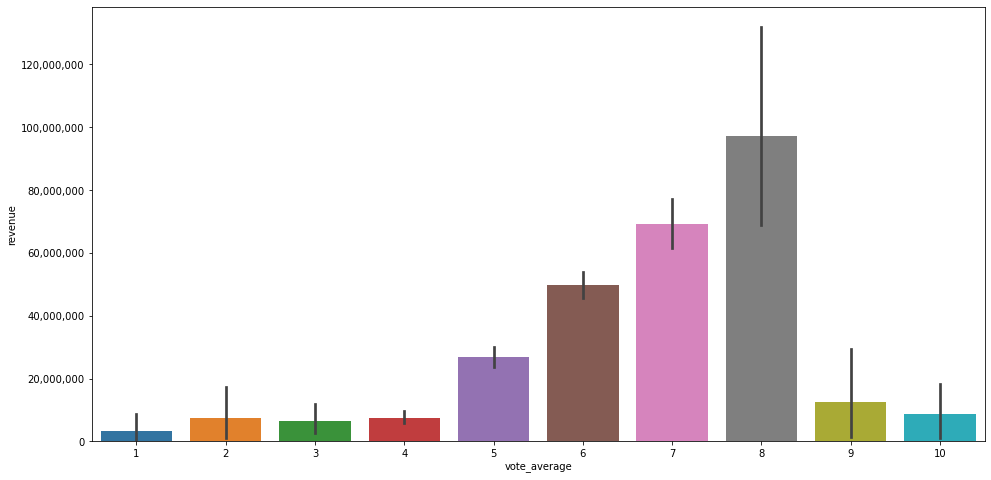

In [169]:
fig,ax=plt.subplots(  figsize=(16,8))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

sns.barplot(x='vote_average', y='revenue', data=full_profit_avgvote_df, ax=ax);

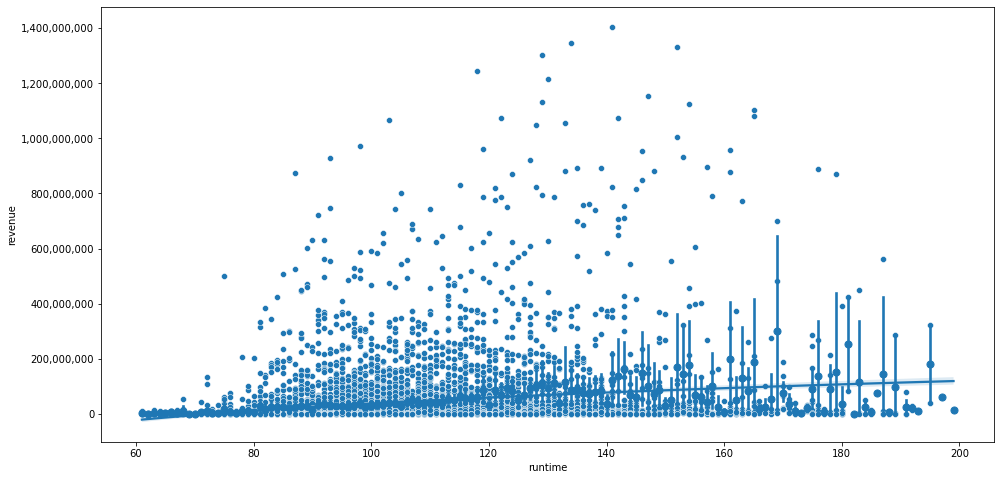

In [179]:
fig,ax=plt.subplots(  figsize=(16,8))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


sns.scatterplot(x='runtime', y='revenue', data=full_profit_runtime_df, ax=ax);

sns.regplot(x='runtime', y='revenue', data=full_profit_runtime_df, ax=ax, x_estimator=np.mean, logx=True);



In [172]:
full_profit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8235 entries, 0 to 8234
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            8235 non-null   int64  
 1   tconst        7693 non-null   object 
 2   title         8235 non-null   object 
 3   release_date  8022 non-null   object 
 4   revenue       8235 non-null   float64
 5   budget        5488 non-null   float64
 6   net_profit    5488 non-null   float64
 7   year          8235 non-null   int32  
 8   vote_average  8235 non-null   int64  
 9   popularity    8235 non-null   int64  
 10  vote_count    8235 non-null   int64  
 11  runtime       8180 non-null   float64
 12  genre_id      7891 non-null   object 
dtypes: float64(4), int32(1), int64(4), object(4)
memory usage: 804.3+ KB
